/opt/conda/lib/python3.11/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
ERROR:bitsandbytes.cextension:Could not load bitsandbytes native library: libcusparse.so.11: cannot open shared object file: No such file or directory
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/bitsandbytes/cextension.py", line 104, in <module>
    lib = get_native_library()
          ^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/bitsandbytes/cextension.py", line 91, in get_native_library
    dll = ct.cdll.LoadLibrary(str(binary_path))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/ctypes/__init__.py", line 454, in LoadLibrary
    return self._dlltype(name)
           ^^^^^^^

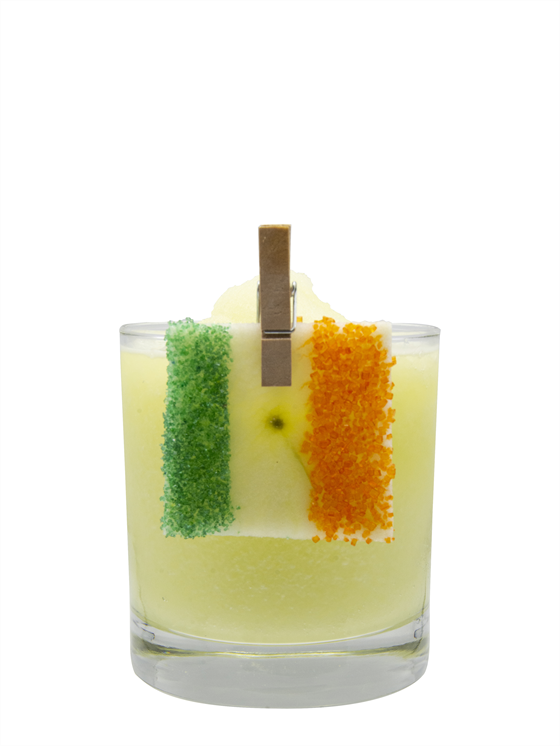

In [1]:
from PIL import Image, ImageOps
from transparent_background import Remover
import numpy as np
from diffusers import ControlNetModel
import os
import torch

img = Image.open("../data/monin/combined_dataset/test/1725657501_6166165.png").convert('RGB')
img

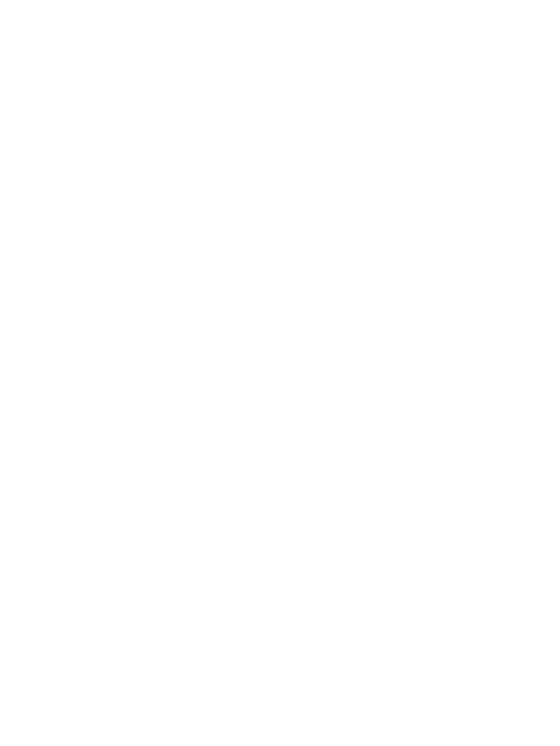

In [2]:
white_img = Image.new('RGB', img.size, color='white')

# Save or display the image
white_img

In [3]:
def plot_images(images):
    from matplotlib import pyplot as plt
    plt.figure()
    f, axarr = plt.subplots(1, len(images), figsize=(20,10))
    for ax, img in zip(axarr.flatten(), images):
        ax.imshow(img)
        ax.axis('off')
    plt.show()

/opt/conda/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Settings -> Mode=base, Device=cuda:0, Torchscript=disabled
Settings -> Mode=base, Device=cuda:0, Torchscript=disabled


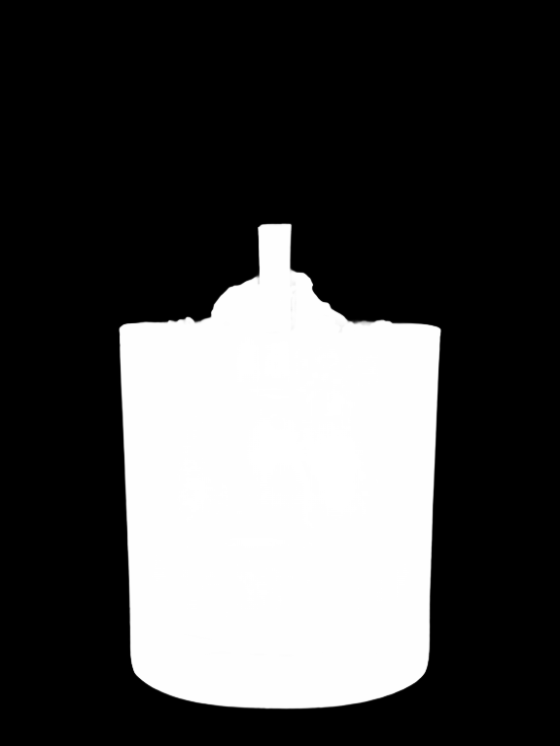

In [4]:
from transparent_background import Remover

remover = Remover()  # default setting
remover = Remover(mode='base')  # nightly release checkpoint

# mask_real = remove(img_real)
mask_real = remover.process(img, type='map')  # default setting - transparent background
mask_real

In [5]:
def _make_inpaint_condition(init_image, mask_image):
        init_image = np.array(init_image.convert("RGB")).astype(np.float32) / 255.0
        mask_image = np.array(mask_image.convert("L")).astype(np.float32) / 255.0
        assert init_image.shape[0:1] == mask_image.shape[0:1], "image and image_mask must have the same image size"
        init_image[mask_image > 0.5] = -1.0 
        init_image = np.expand_dims(init_image, 0).transpose(0, 3, 1, 2)
        init_image = torch.from_numpy(init_image)
        return init_image

fg_img = _make_inpaint_condition(img, mask_real)
fg_img

tensor([[[[0.9922, 0.9922, 0.9922,  ..., 0.9922, 0.9922, 0.9922],
          [0.9922, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9922],
          [0.9922, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9922],
          ...,
          [0.9922, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9922],
          [0.9922, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9922],
          [0.9922, 0.9922, 0.9922,  ..., 0.9922, 0.9922, 0.9922]],

         [[0.9922, 0.9922, 0.9922,  ..., 0.9922, 0.9922, 0.9922],
          [0.9922, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9922],
          [0.9922, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9922],
          ...,
          [0.9922, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9922],
          [0.9922, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9922],
          [0.9922, 0.9922, 0.9922,  ..., 0.9922, 0.9922, 0.9922]],

         [[0.9922, 0.9922, 0.9922,  ..., 0.9922, 0.9922, 0.9922],
          [0.9922, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9922],
          [0.9922, 1.0000, 1.0000,  ..., 1

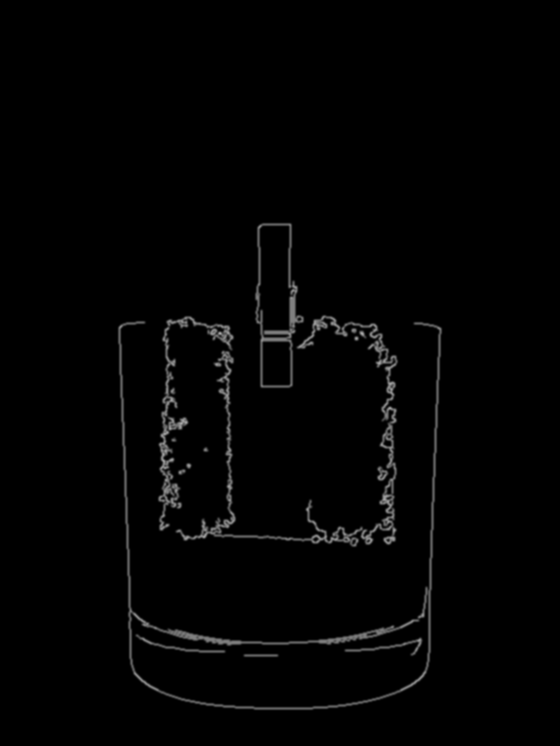

In [6]:
import cv2

import numpy as np

low_threshold = 150
high_threshold = 400
# low_threshold = 550
# high_threshold = 650

# image = np.array(background_img)
image = np.array(img)
image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
# Apply Gaussian blur to the Canny image (you can adjust kernel size (5, 5) and sigma as needed)
blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

# Convert to PIL image for display or further processing
canny_image = Image.fromarray(blurred_image)

canny_image

In [9]:


from diffusers import StableDiffusionPipeline
from diffusers import DiffusionPipeline
from diffusers import StableDiffusionControlNetPipeline, StableDiffusionControlNetInpaintPipeline, StableDiffusionXLControlNetInpaintPipeline, StableDiffusionXLInpaintPipeline, StableDiffusionXLPipeline
from diffusers import StableDiffusionXLControlNetPipeline


# runwayml/stable-diffusion-v1-5

controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)

# controlnet = ControlNetModel.from_pretrained("diffusers/controlnet-canny-sdxl-1.0", torch_dtype=torch.float16)

# controlnets = [
#     # ControlNetModel.from_pretrained("alimama-creative/EcomXL_controlnet_inpaint", torch_dtype=torch.float16),
#     # ControlNetModel.from_pretrained("/pipelines/sdxl-controlnet-napitochki", torch_dtype=torch.float16),
#     ControlNetModel.from_pretrained("diffusers/controlnet-canny-sdxl-1.0", torch_dtype=torch.float16),
# ]

    
# pipeline = StableDiffusionXLControlNetPipeline.from_pretrained(
#     "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, controlnet=controlnets
# ).to("cuda")
# pipeline = StableDiffusionXLPipeline.from_pretrained(
#     "../../SceneGenAI/notebooks/pipelines/sdxl-model-finetuned", torch_dtype=torch.float16
#     # "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16
# ).to("cuda")

# pipeline = DiffusionPipeline.from_pretrained(
#     "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16
# ).to("cuda")

# prompt = "Name: 'Luck Of The Irish' Frozen Lemonade; Recipie: 3/4 oz. Monin Pistachio Syrup\n3/4 oz. Monin Ginger Syrup\n2 oz. fresh lemon sour mix\n\nFill serving glass full of ice.\nPour ingredients into blender cup in order listed.\nAdd ice from serving glass, cap, and blend until smooth.\nPour back into serving glass, add garnish and serve.; Category: lemonade"
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained("../models/monin", torch_dtype=torch.float16, controlnet=controlnet)
# images = pipeline(
#     prompt,
#     # image=white_img,
#     # control_image=canny_image,
#     # mask_image=mask_real,
#     # guidance_scale=10,
#     # num_inference_steps=50,
#     # generator=torch.Generator(device='cpu').manual_seed(42),
#     # controlnet_conditioning_scale=1.0, 
#     num_images_per_prompt=6
# ).images




pipe = pipe.to("cuda")
prompt = "Name: 'Luck Of The Irish' Frozen Lemonade; Recipie: 3/4 oz. Monin Pistachio Syrup\n3/4 oz. Monin Ginger Syrup\n2 oz. fresh lemon sour mix\n\nFill serving glass full of ice.\nPour ingredients into blender cup in order listed.\nAdd ice from serving glass, cap, and blend until smooth.\nPour back into serving glass, add garnish and serve.; Category: lemonade"
negative_prompt = 'low quality, bad quality, sketches'
controlnet_conditioning_scale = 0.5

images = pipe(prompt=prompt, negative_prompt=negative_prompt, image=white_img, control_image=canny_image, mask_image=mask_real, num_images_per_prompt=6).images

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (85 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['garnish and serve .; category : lemonade']


  0%|          | 0/50 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

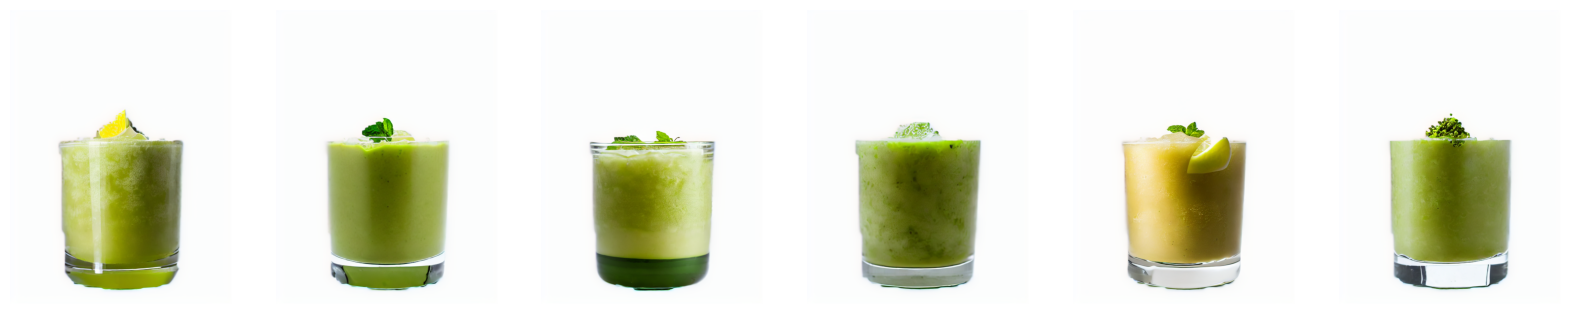

In [10]:
plot_images(images)